## Citizen Feedback Classification
This notebook contains the implementation of citizen feedback classification using Logistic Regression.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Load datasets
df_train = pd.read_csv("../data/datav6.csv")
df_test = pd.read_csv("../data/test.csv")

# Extract features and labels
X_train = df_train["comment"]
y_train = df_train["label"].map(
    {"complaint": 0, "inquiry": 1, "suggestion": 2, "compliment": 3})
X_test = df_test["comment"]
y_test = df_test["label"].map(
    {"complaint": 0, "inquiry": 1, "suggestion": 2, "compliment": 3})


In [3]:
# Convert text to TF-IDF features
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()


In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Numerical stability
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)


def train_logistic_regression(X, y, lr=0.01, epochs=1000):
    m, n = X.shape
    k = len(np.unique(y))  # Number of classes
    weights = np.zeros((n, k))
    bias = np.zeros(k)
    y_one_hot = np.eye(k)[y]  # One-hot encoding

    train_accuracy = []
    for _ in range(epochs):
        linear_model = np.dot(X, weights) + bias
        predictions = softmax(linear_model)

        error = predictions - y_one_hot

        weights -= lr * np.dot(X.T, error) / m
        bias -= lr * np.mean(error, axis=0)

        train_accuracy.append(accuracy_score(y, np.argmax(predictions, axis=1)))

    return weights, bias, train_accuracy


def predict(X, weights, bias):
    linear_model = np.dot(X, weights) + bias
    predictions = softmax(linear_model)
    return np.argmax(predictions, axis=1)



In [6]:
weights, bias, train_accuracy = train_logistic_regression(X_train_tfidf,
                                                          y_train.to_numpy(), epochs=10)

In [7]:
y_pred = predict(X_test_tfidf, weights, bias)

## Evaluation and Visualization

In [12]:
label_map = {0: "Complaint", 1: "Inquiry", 2: "Suggestion", 3: "Compliment"}
y_pred_labels = np.array([label_map[val] for val in y_pred])
y_test_labels = np.array([label_map[val] for val in y_test])

print("Accuracy on Training Data:",
      accuracy_score(y_train, predict(X_train_tfidf, weights, bias)))
print("Accuracy on Testing Data:", accuracy_score(y_test, y_pred))
print("Classification Report:")
report = classification_report(y_test_labels, y_pred_labels,zero_division=0, output_dict=True)
print(classification_report(y_test_labels, y_pred_labels, zero_division=0))


Accuracy on Training Data: 1.0
Accuracy on Testing Data: 0.7
Classification Report:
              precision    recall  f1-score   support

   Complaint       0.67      0.40      0.50         5
  Compliment       0.67      0.80      0.73         5
     Inquiry       0.80      0.80      0.80         5
  Suggestion       0.67      0.80      0.73         5

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.69        20
weighted avg       0.70      0.70      0.69        20



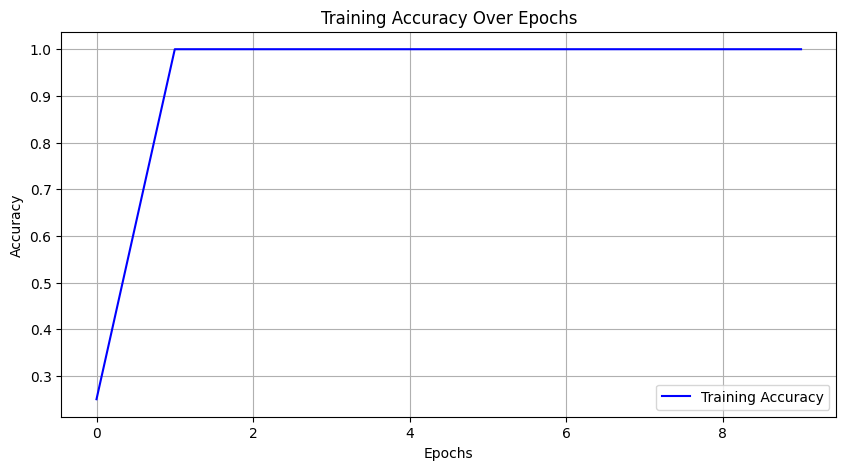

In [9]:
# After training the model, get
# 1. Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

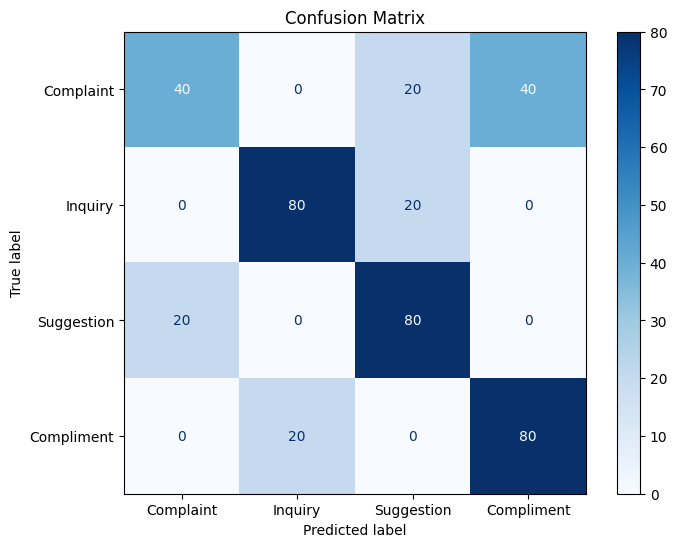

In [14]:

# 2. Confusion Matrix
y_pred = predict(X_test_tfidf, weights, bias)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Save the confusion matrix
np.save('../reports/confusion_matrix_logistic_regression.npy', cm)

cm_percent = cm.astype('float') / cm.sum(axis=1)[:,
                                  np.newaxis] * 100  # Convert to percentage

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm_percent,
                       display_labels=['Complaint', 'Inquiry', 'Suggestion',
                                       'Compliment']).plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix')
plt.show()


## Saving the classification Report

In [11]:
import json

In [13]:
# Save to JSON file
with open('../reports/classification_report_logistic_regression.json', 'w') as f:
    json.dump(report, f)

<center>
<h3> Thank You </h3>
</center>